In [ ]:
# Mount google drive, install rasterio
import os, numpy as np, pandas as pd, random, sys
modeltype = "unet"
dataname = "lang"
path = "/content/drive/My Drive/jöklar/"
sys.path.append(path + "src")
from util.util import install_import
install_import("rasterio")
import rasterio
model_path = path + "results/" + modeltype + "/"
data_path = path + "data/" + dataname + "/"
os.makedirs(model_path, exist_ok=True)
os.chdir(model_path)

In [ ]:
# Read image data
%%time
(img, mask, is_on_border, train, val, test) = (np.load(data_path +
                                              "images.npz").values())
X = img[is_on_border].astype(np.float32)/10000
Y = mask[is_on_border]

CPU times: user 2.48 s, sys: 1.75 s, total: 4.23 s
Wall time: 24.4 s


In [ ]:
# Read training history, best model and model predictions
from tensorflow.keras.models import load_model
history = pd.read_csv('result_history.csv')
model = load_model('model_first.keras')
model.load_weights('model_best.keras')
print(history[-3:])
loaded = np.load("probs.npz")
(probs, test_loss, test_accuracy) = loaded.values()
train_probs = probs[train]
val_probs = probs[val]
test_probs = probs[test]
print(f"Test accuracy: {test_accuracy}")

    Unnamed: 0      loss  accuracy  val_loss  val_accuracy       lr
57          57  0.019089  0.996307  0.054209      0.983546  0.00001
58          58  0.018962  0.996347  0.053896      0.983696  0.00001
59          59  0.018952  0.996291  0.053935      0.983700  0.00001
Test accuracy: 0.9850702285766602


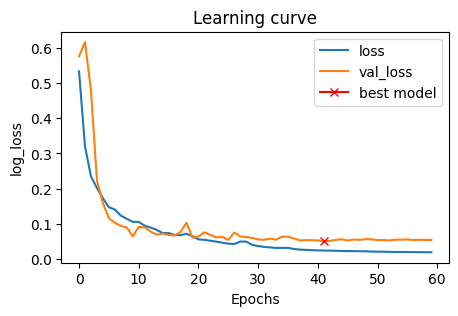

In [ ]:
# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.title("Learning curve")
plt.plot(history.loss, label="loss")
plt.plot(history.val_loss, label="val_loss")
plt.plot(np.argmin(history.val_loss), history.val_loss.min(), marker="x",
         color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

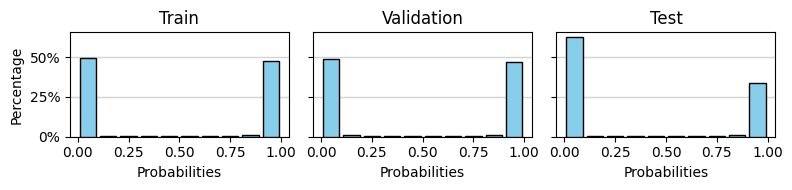

In [ ]:
# Plot probabilities according to data split
from matplotlib.ticker import PercentFormatter
fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharey=True)
datasets = [train_probs, val_probs, test_probs]
labels = ['Train', 'Validation', 'Test']
for i, (data, label) in enumerate(zip(datasets, labels)):
    axes[i].hist(data.ravel(), bins=10, range=(0, 1), rwidth=0.8, color='skyblue',
                 ec='k', zorder=3, density=True)
    axes[i].set_xlabel('Probabilities')
    axes[i].set_ylabel('Percentage' if i == 0 else '')
    axes[i].set_title(label)
    axes[i].grid(True, axis='y', linestyle='-', lw=1, color='lightgray', zorder=0)
    #if i==0:
    axes[i].yaxis.set_major_formatter(PercentFormatter(10, decimals=0))
plt.tight_layout()
plt.show()

In [ ]:
def plot_sample(X, y, preds, binary_preds, indices):
    """Function to plot the results"""
    nrows = len(indices):
    print(ix)
    for (irow, ix) in enumerate(indices):
      has_mask = y[ix].max() > 0
      fig, ax = plt.subplots(nrows, 4, figsize=(12,3))

      ax[irow].imshow(X[ix, ..., 0])
      if has_mask:
          ax[irow].contour(y[ix].squeeze(), colors='k', levels=[0.5])
      if ix == indices[0]:
        ax[i].set_title('Original')

        ax[1].imshow(y[ix].squeeze(), cmap = 'gray')
        ax[1].set_title('Mask')

        ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap = 'gray')
        if has_mask:
            ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
        ax[2].set_title('Glaciers Predicted')

        ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap = 'gray')
        if has_mask:
            ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
        ax[3].set_title('Glaciers Predicted binary');
# Check if training data looks all right
train_probs_01 = (train_probs > 0.5).astype(np.uint8)
plot_sample(img[train], mask[train], train_probs, train_probs_01, 69)

SyntaxError: invalid syntax (<ipython-input-9-b8e8ccedfbb8>, line 3)

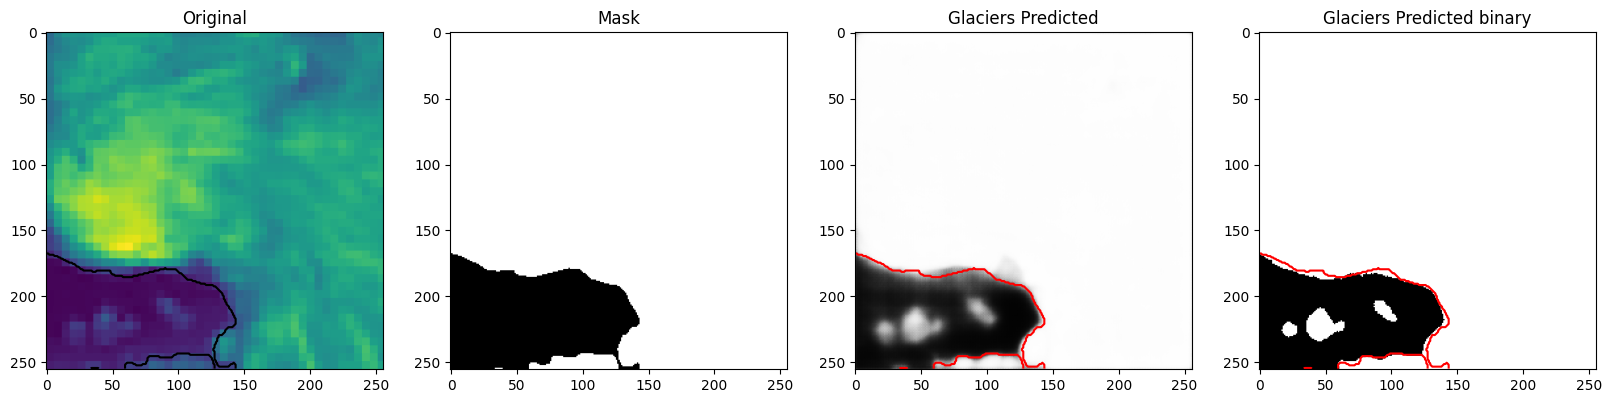

In [ ]:
# Check if validation data looks all right
plot_sample(img[val], mask[val], val_probs, val_probs_t)

In [ ]:
# Predict each image and write the output as mask raster
# Mýr
# n_images = 115
# Lan
import rasterio, json
from cnn_util.meta_util import dejsonify_list
n_images = len(img)
n_channels = 13
threshold = 0.5
with open('meta.json') as f:
    meta_list = dejsonify_list(json.load(f))
print(os.getcwd())
for i in range(n_images):
  f = rasterio.open("/content/drive/MyDrive/tif_img_256_lan_more/img_" + str(i) + ".tif")
  prediction_t = (probs[i] > threshold).astype(np.uint8)
  meta = meta_list[i]
  meta["nodata"] = 0
  meta["count"] = 1
  new_arr = np.rollaxis(prediction_t[:,:,:], 2, 0)
  filename = "test" + str(i) + ".tif"
  print(filename)
  with rasterio.open(filename, "w", **meta) as dest:
    dest.write(new_arr)

/content/drive/Othercomputers/My MacBook Air/drive/jöklar
test0.tif
test1.tif
test2.tif
test3.tif
test4.tif
test5.tif
test6.tif
test7.tif
test8.tif
test9.tif
test10.tif
test11.tif
test12.tif
test13.tif
test14.tif
test15.tif
test16.tif
test17.tif
test18.tif
test19.tif
test20.tif
test21.tif
test22.tif
test23.tif
test24.tif
test25.tif
test26.tif
test27.tif
test28.tif
test29.tif
test30.tif
test31.tif
test32.tif
test33.tif
test34.tif
test35.tif
test36.tif
test37.tif
test38.tif
test39.tif
test40.tif
test41.tif
test42.tif
test43.tif
test44.tif
test45.tif
test46.tif
test47.tif
test48.tif
test49.tif
test50.tif
test51.tif
test52.tif
test53.tif
test54.tif
test55.tif
test56.tif
test57.tif
test58.tif
test59.tif
test60.tif
test61.tif
test62.tif
test63.tif
test64.tif
test65.tif
test66.tif
test67.tif
test68.tif
test69.tif
test70.tif
test71.tif
test72.tif
test73.tif
test74.tif
test75.tif
test76.tif
test77.tif
test78.tif
test79.tif
test80.tif
test81.tif
test82.tif
test83.tif
test84.tif
test85.tif
test86

In [ ]:
os.getcwd()

'/content/drive/Othercomputers/My MacBook Air/drive/jöklar'

# **Búa til nýjar útlínur**

In [ ]:
img.shape

(197, 256, 256, 13)

In [ ]:
import glob
from osgeo import gdal
import subprocess

demList = glob.glob("test*.tif")
print(len(demList))

197


In [ ]:
vrt = gdal.BuildVRT("merged.vrt", demList)
gdal.Translate("mergedDEM-deeplab-mobilenet-myr.tif", vrt, xRes=10, yRes=-10)
vrt = None

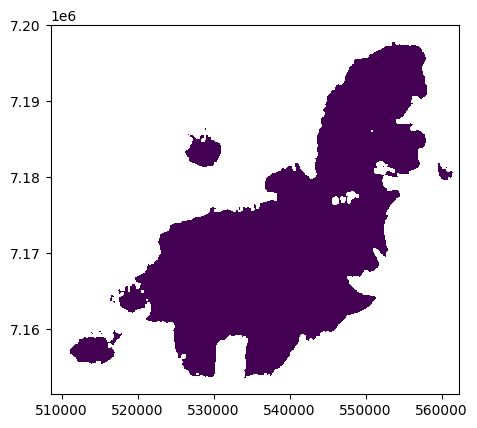

<Axes: >

In [ ]:
from rasterio.plot import show
r = rasterio.open("mergedDEM-deeplab-mobilenet-myr.tif")
show(r)

In [ ]:
!gdal_polygonize.py mergedDEM-deeplab-mobilenet-myr.tif -f "ESRI Shapefile" mergedDEM-deeplab-mobilenet-myr.shp

0...10...20...30...40...50...60...70...80...90...100 - done.


<Axes: >

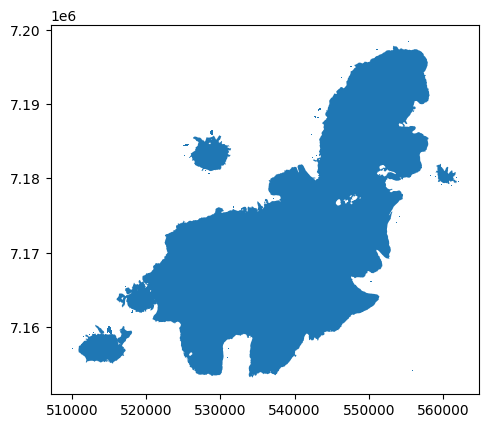

In [ ]:
import geopandas as gpd
stat = gpd.read_file("mergedDEM-deeplab-mobilenet-myr.shp")
stat.plot()